<a href="https://colab.research.google.com/github/sysiphe0/kaggle/blob/main/kaggle_santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## #1. read file

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import matplotlib
from google.colab import drive

In [2]:
def chk_dup_features(df):
  remove = []
  c = df.columns
  for i in range(len(c)-1):
    v = df[c[i]].values
    for j in range(i+1, len(c)):
      if np.array_equal(v, df[c[j]].values):
        remove.append(c[j])
  return list(set(remove))

In [3]:
def chk_constant_features(df):
  remove = []
  c = df.columns
  for i in range(len(c)-1):
    if df[c[i]].std() == 0:
      remove.append(c[i])
  return remove

In [4]:
def read_train_test_data(path):
  # read train/test csv data
  train_df = pd.read_csv("/content/drive/My Drive/"+path+"/train.csv")
  test_df = pd.read_csv("/content/drive/My Drive/"+path+"/test.csv")
  # replace outlier
  train_df['var3'].replace(-999999,2,inplace=True)
  # separate ID feature and drop it (for making submission file)
  test_id = test_df.ID
  train_df.drop('ID', axis=1, inplace=True)
  test_df.drop('ID', axis=1, inplace=True)
  # separate TARGET feature and drop it
  train_labels = train_df.TARGET
  train_df.drop('TARGET',axis=1, inplace=True)
  # return result
  return train_df, test_df, test_id, train_labels

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_df, test_df, test_id, train_labels = read_train_test_data('santander')
print(train_df.shape, test_df.shape, test_id.shape, train_labels.shape)

(76020, 369) (75818, 369) (75818,) (76020,)


## #2. Feature Selection

#### 1)  remove duplicated features

In [7]:
# check from test-set and drop it
remove_dup_1 = chk_dup_features(test_df)
train_df.drop(remove_dup_1, axis=1, inplace=True)
test_df.drop(remove_dup_1, axis=1, inplace=True)
# check from train-set and drop it
remove_dup_2 = chk_dup_features(train_df)
train_df.drop(remove_dup_2, axis=1, inplace=True)
test_df.drop(remove_dup_2, axis=1, inplace=True)
print(len(remove_dup_1), len(remove_dup_2), train_df.shape, test_df.shape)

69 2 (76020, 298) (75818, 298)


#### 2) remove constant features

In [8]:
# check from test-set and drop it
remove_con_1 = chk_constant_features(test_df)
train_df.drop(remove_con_1, axis=1, inplace=True)
test_df.drop(remove_con_1, axis=1, inplace=True)
# check from train-set and drop it
remove_con_2 = chk_constant_features(train_df)
train_df.drop(remove_con_2, axis=1, inplace=True)
test_df.drop(remove_con_2, axis=1, inplace=True)
print(len(remove_con_1), len(remove_con_2), train_df.shape, test_df.shape)

1 0 (76020, 297) (75818, 297)


#### 3) remove quasi-constant features

In [9]:
from sklearn.feature_selection import VarianceThreshold
# threshold = 0.01 (to remove feature which variance is under 0.01)
sel = VarianceThreshold(threshold=0.01)
# check from test-set and remove it
sel.fit(test_df)
sum_vt_1 = sum(sel.get_support())
train_q = sel.transform(train_df)
test_q = sel.transform(test_df)
# check from train-set and remove it
sel.fit(train_q)
sum_vt_2 = sum(sel.get_support())
train_q = sel.transform(train_q)
test_q = sel.transform(test_q)
print(sum_vt_1, sum_vt_2, train_q.shape, test_q.shape)

249 247 (76020, 247) (75818, 247)


#### 4) Univariate feature selection

In [ ]:
# not used
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import SelectPercentile
#from sklearn.feature_selection import f_classif  

#train_kb = SelectKBest(f_classif, k=10).fit_transform(train_df, train_labels)
#train_kb.shape

#### 5) train/test 분리

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_q, train_labels, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60816, 247) (15204, 247) (60816,) (15204,)


####   6) 중요도 높은 feature만 선택하여 진행 (xgboost 활용)

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

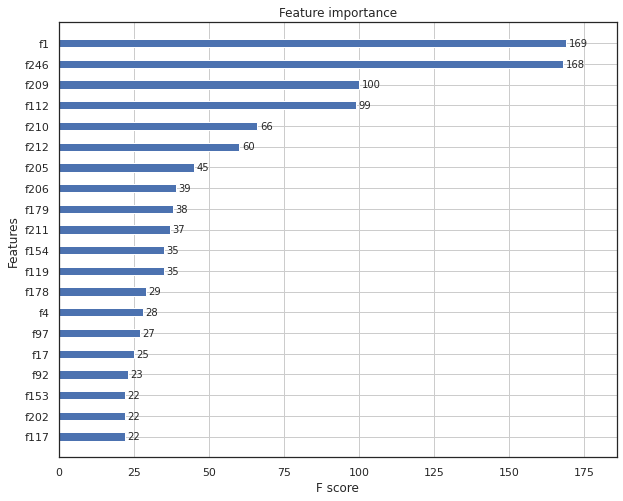

In [11]:
# train and draw a plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [ ]:
# select important features from model
from sklearn.feature_selection import SelectFromModel

fs = SelectFromModel(xgb_clf, prefit = True)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test_q = fs.transform(test_q)
print(X_train.shape, X_test.shape, test_q.shape)

## 3-1. 학습 수행 (xgboost)
#### 1) Hyperparameter 최적화

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)
params = {'max_depth':[5,7],'colsample_bytree':[0.5,0.85], 'learning_rate':[0.02,0.03]}
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(xgb_roc_score, gridcv.best_params_)

#### 1) [xgboost] 학습

In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.03, max_depth=7, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.03, nthread=4, subsample=0.9, seed=4242)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
xgb_roc_score

#### 2) [xgboost] submission 결과 추출

In [ ]:
probs = xgb_clf.predict_proba(test_q)
submission = pd.DataFrame({"ID":test_id, "TARGET":probs[:,1]})
submission.to_csv("/content/drive/My Drive/santander/submission_201011_xgboost_1.csv", index=False)

## #4. PCA

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

In [ ]:
X_train_nor = normalize(X_train, axis=0)
X_test_nor = normalize(X_test, axis=0)
test_q_nor = normalize(test_q, axis=0)

X_train_pca = pca.fit_transform(X_train_nor)
X_test_pca = pca.fit_transform(X_test_nor)
test_q_pca = pca.fit_transform(test_q_nor)

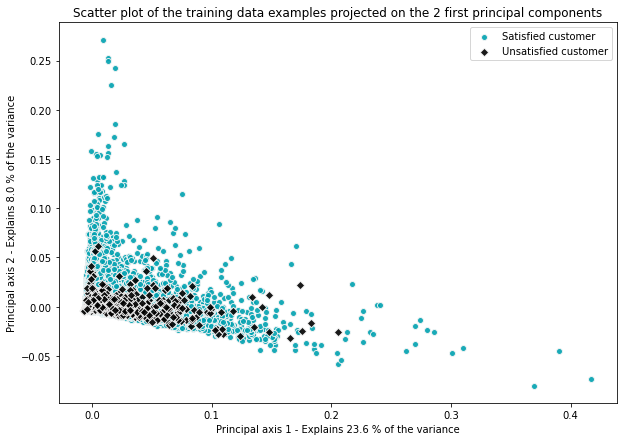

In [ ]:
classes = np.sort(np.unique(y_train))
labels = ["Satisfied customer", "Unsatisfied customer"]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
colors = [(0.0, 0.63, 0.69), 'black']
markers = ["o", "D"]
for class_ix, marker, color, label in zip(classes, markers, colors, labels):
  ax.scatter(X_train_pca[np.where(y_train==class_ix), 0],
             X_train_pca[np.where(y_train==class_ix), 1],
             marker=marker, color=color, edgecolor = "whitesmoke", linewidth=1,
             alpha=0.9, label=label)
  ax.legend(loc='best')
plt.title("Scatter plot of the training data examples projected on the "
        "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

In [ ]:
print(X_train_pca.shape, X_test_pca.shape, test_q_pca.shape)

(60816, 5) (15204, 5) (75818, 5)


In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.03, max_depth=7, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.03, nthread=4, subsample=0.9, seed=4242)
xgb_clf.fit(X_train_pca, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_pca)[:,1], average='macro')
xgb_roc_score

[0]	validation_0-auc:0.758206	validation_1-auc:0.516401
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.773569	validation_1-auc:0.518825
[2]	validation_0-auc:0.772644	validation_1-auc:0.518964
[3]	validation_0-auc:0.778669	validation_1-auc:0.393478
[4]	validation_0-auc:0.780133	validation_1-auc:0.395063
[5]	validation_0-auc:0.781354	validation_1-auc:0.396704
[6]	validation_0-auc:0.783372	validation_1-auc:0.372845
[7]	validation_0-auc:0.784254	validation_1-auc:0.372268
[8]	validation_0-auc:0.786532	validation_1-auc:0.397709
[9]	validation_0-auc:0.791055	validation_1-auc:0.409337
[10]	validation_0-auc:0.792612	validation_1-auc:0.399732
[11]	validation_0-auc:0.794416	validation_1-auc:0.405086
[12]	validation_0-auc:0.795697	validation_1-auc:0.409827
[13]	validation_0-auc:0.797029	validation_1-auc:0.413208
[14]	validation_0-auc:0.797529	validation_1-auc:0.40172

0.5189641435125545

## 3-2. 학습 수행 (LightGBM)
#### 1) Hyperparameter 최적화

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
          'subsample':[0.8,1],
          'boost_from_average':[False]}

In [ ]:
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print(gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(lgbm_roc_score)

[1]	valid_0's auc: 0.823554	valid_0's binary_logloss: 0.156219	valid_1's auc: 0.820798	valid_1's binary_logloss: 0.164916
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.829602	valid_0's binary_logloss: 0.150938	valid_1's auc: 0.824674	valid_1's binary_logloss: 0.159815
[3]	valid_0's auc: 0.835085	valid_0's binary_logloss: 0.147168	valid_1's auc: 0.826003	valid_1's binary_logloss: 0.156207
[4]	valid_0's auc: 0.839626	valid_0's binary_logloss: 0.144235	valid_1's auc: 0.83037	valid_1's binary_logloss: 0.153427
[5]	valid_0's auc: 0.842434	valid_0's binary_logloss: 0.141776	valid_1's auc: 0.832747	valid_1's binary_logloss: 0.151113
[6]	valid_0's auc: 0.845739	valid_0's binary_logloss: 0.13968	valid_1's auc: 0.835154	valid_1's binary_logloss: 0.149347
[7]	valid_0's auc: 0.846345	valid_0's binary_logloss: 0.138007	valid_1's auc: 0.835698	valid_1's binary_logloss: 0.14776
[8]	valid_0's auc: 0.849153	valid_0's binary_logloss: 0.13654	valid_1's auc: 0.83691	va

NameError: ignored

In [ ]:
print(gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(lgbm_roc_score)

{'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}
0.8412062186464128


In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=60, max_depth=128, boost_from_average=False)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(lgbm_roc_score)

[1]	valid_0's auc: 0.81744	valid_0's binary_logloss: 0.165128
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.820421	valid_0's binary_logloss: 0.159978
[3]	valid_0's auc: 0.827206	valid_0's binary_logloss: 0.156423
[4]	valid_0's auc: 0.8329	valid_0's binary_logloss: 0.153502
[5]	valid_0's auc: 0.836038	valid_0's binary_logloss: 0.151221
[6]	valid_0's auc: 0.837409	valid_0's binary_logloss: 0.149316
[7]	valid_0's auc: 0.838612	valid_0's binary_logloss: 0.147774
[8]	valid_0's auc: 0.84006	valid_0's binary_logloss: 0.146429
[9]	valid_0's auc: 0.840087	valid_0's binary_logloss: 0.145418
[10]	valid_0's auc: 0.840505	valid_0's binary_logloss: 0.14451
[11]	valid_0's auc: 0.841206	valid_0's binary_logloss: 0.143585
[12]	valid_0's auc: 0.840401	valid_0's binary_logloss: 0.143032
[13]	valid_0's auc: 0.840386	valid_0's binary_logloss: 0.142428
[14]	valid_0's auc: 0.839586	valid_0's binary_logloss: 0.142059
[15]	valid_0's auc: 0.839195	valid_0's binary_logloss: 

In [ ]:
probs = lgbm_clf.predict_proba(test_df)
submission = pd.DataFrame({"ID":test_id, "TARGET":probs[:,1]})
submission.to_csv("/content/drive/My Drive/santander/submission_201010_lgbm_1.csv", index=False)

In [ ]:
submission.head()

,ID,TARGET
0,2,0.032658
1,5,0.042919
2,6,0.015702
3,7,0.018131
4,9,0.015702
